# ocroseg

This is a deep learning model for page layout analysis / segmentation.

There are many different ways in which you can train and run it, but by default, it will simply return the text lines in a page image.

(Show the talk slides first.)

In [2]:
%%bash
model=lowskew-000000259-011440.pt
test -f $model || wget --quiet -nd https://storage.googleapis.com/tmb-models/$model

In [11]:
%pylab inline
rc("image", cmap="gray", interpolation="bicubic")
figsize(10, 10)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Segmentation

Segmentation is carried out using the `ocroseg.Segmenter` class. This needs a model that you can download or train yourself.

In [4]:
import ocroseg
seg = ocroseg.Segmenter("lowskew-000000259-011440.pt")
seg.model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (10): ReLU()
  (11): LSTM2(
    (hlstm): RowwiseLSTM(
      (lstm): LSTM(64, 32, bidirectional=1)
    )
    (vlstm): RowwiseLSTM(
      (lstm): LSTM(64, 32, bidirectional=1)
    )
  )
  (12): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (14): ReLU()
  (15): LSTM2(
    (hlstm): RowwiseLSTM(
      (lstm): LSTM(32, 32

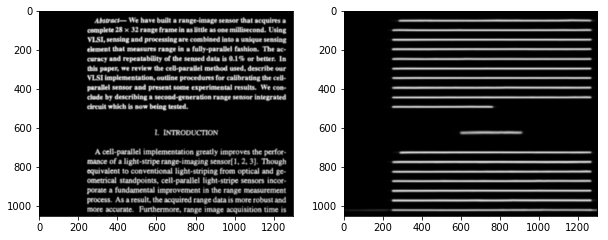

In [6]:
# the DL model computes text line seeds
image = 1.0 - imread("testdata/W1P0.png")[950:2000,:1300] # NB: data is binarized, reversed

probs = seg.line_probs(image)

subplot(121); imshow(image); subplot(122); imshow(probs)

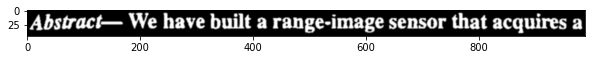

In [7]:
# another method uses these text line seed to extract text lines
lines = seg.extract_textlines(image)
imshow(lines[0]["image"])

# Training

The text line segmenter is trained using pairs of page images and line images stored in `tar` files. Here we use "framed" inputs, meaning inputs in which marginal noise has been removed. 

In [9]:
%%bash
tar -ztvf testdata/framedlines.tgz | sed 6q

-rw-rw-r-- tmb/tmb      110404 2017-03-19 16:47 A001BIN.framed.png
-rw-rw-r-- tmb/tmb       10985 2017-03-16 16:15 A001BIN.lines.png
-rw-rw-r-- tmb/tmb       74671 2017-03-19 16:47 A002BIN.framed.png
-rw-rw-r-- tmb/tmb        8528 2017-03-16 16:15 A002BIN.lines.png
-rw-rw-r-- tmb/tmb      147716 2017-03-19 16:47 A003BIN.framed.png
-rw-rw-r-- tmb/tmb       12023 2017-03-16 16:15 A003BIN.lines.png


tar: write error


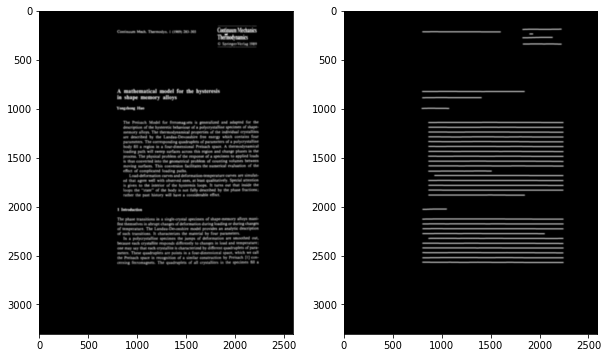

In [10]:
from dlinputs import tarrecords
sample = tarrecords.tariterator(open("testdata/framedlines.tgz")).next()
subplot(121); imshow(sample["framed.png"])
subplot(122); imshow(sample["lines.png"])

# Masked Training

- We can tell the DL system which parts of an image to pay attention to with a mask.
  - masked to near the text lines: the system will try to find text lines anywhere
  - unmasked and unframed: the system will actively try to remove border noise because the ground truth forces it to output "no lines"

# Common Kinds of Models

- framed to textlines, masked: simple text line finder
- framed to textlines, unmasked: text line finder and text/image discrimination
- unframed to textlines, unmasked: text line finder, text/image discrimination, border noise removal

# Possible Kinds of Input

- binary, low skew: scanned, dewarped, skew-corrected pages
- high skew (binary or gray): text line finding for dewarping and direct recognitioni

# Open Issues / Future Work

- much larger training sets
- semi-supervised / self-supervised training
- extension to gray scale / photographic images of pages
- replace logic for extraction from seeds with trainable model
- learning reading order
- table recognition
- or... replace it all with more human-like reading